In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
#from tensorflow import keras
import keras
import matplotlib.pyplot as plt
from vis.visualization import visualize_saliency
from vis.visualization import get_num_filters
from vis.visualization import visualize_activation
from vis.utils import utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras import activations

/users/ai/u7ysrv/anaconda3/envs/samel/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/ai/u7ysrv/anaconda3/envs/samel/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/ai/u7ysrv/anaconda3/envs/samel/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/ai/u7ysrv/anaconda3/envs/samel

# 1. Loading Data 

## Read dataset

In [2]:
data = tf.keras.datasets.mnist

In [3]:
(trainX, trainY),(testX, testY) = data.load_data()

In [4]:
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

In [5]:
trainY = keras.utils.to_categorical(trainY, 10)
testY = keras.utils.to_categorical(testY, 10)

In [6]:
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

In [7]:
print(trainX.shape)

(60000, 28, 28, 1)


# Training

## Code for training

In [8]:
#Creates Sequential model using Keras
#Number of nodes is the same as number of features (different number of nodes were tried but it did not
#affect validation accuracy significantly)
lenet = keras.Sequential([
                            #Input layer:
                            keras.layers.Conv2D(20, 5, padding="same", input_shape=[28,28,1], use_bias=True),
                            #Hidden Layers:
                            keras.layers.Activation(activation="relu"),
                            keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                            keras.layers.Conv2D(50, 5, padding="same"),
                            keras.layers.Activation(activation="relu"),
                            keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
                            keras.layers.Flatten(),
                            keras.layers.Dense(500),
                            keras.layers.Activation(activation="relu"),
                            keras.layers.Dense(10, name='vis',use_bias=True),
                            #Output layer
                            keras.layers.Activation(activation="softmax"),
                        ])

In [9]:
#lenets = [keras.models.clone_model(lenet),keras.models.clone_model(lenet),keras.models.clone_model(lenet),keras.models.clone_model(lenet),keras.models.clone_model(lenet),keras.models.clone_model(lenet)]

In [10]:
classifier_number = 5
lenets = [keras.models.clone_model(lenet)]
for i in range(1,classifier_number):
    lenets.append(keras.models.clone_model(lenet))

In [11]:
#Compiles sequential model
#Using learning rate 0.01
#Loss function will be categorical crossentropy
lenet.compile(
                optimizer=keras.optimizers.SGD(lr=0.01),
                loss = 'categorical_crossentropy',
                metrics = ['accuracy']
                )
#Trains network over a number of epochs and evaluates network agains validation data
#after each epoch
lenetEpochHistory = lenet.fit(trainX, trainY, epochs = 5, validation_data = (testX, testY))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 17s 277us/step - loss: 0.4308 - acc: 0.8802 - val_loss: 0.1352 - val_acc: 0.9570
Epoch 2/5
60000/60000 [==============================] - 12s 201us/step - loss: 0.1063 - acc: 0.9678 - val_loss: 0.0708 - val_acc: 0.9774
Epoch 3/5
60000/60000 [==============================] - 12s 201us/step - loss: 0.0741 - acc: 0.9777 - val_loss: 0.0530 - val_acc: 0.9833
Epoch 4/5
60000/60000 [==============================] - 12s 198us/step - loss: 0.0600 - acc: 0.9816 - val_loss: 0.0433 - val_acc: 0.9857
Epoch 5/5
60000/60000 [==============================] - 12s 199us/step - loss: 0.0496 - acc: 0.9849 - val_loss: 0.0424 - val_acc: 0.9870


In [12]:
#Compiles sequential model
#Using learning rate 0.01
#Loss function will be categorical crossentropy
for model in lenets:
    model.compile(
                    optimizer=keras.optimizers.SGD(lr=0.01),
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy']
                    )
#Trains network over a number of epochs and evaluates network agains validation data
#after each epoch
for model in lenets:
    model.fit(trainX, trainY, epochs = 5, validation_data = (testX, testY))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 13s 211us/step - loss: 0.3996 - acc: 0.8828 - val_loss: 0.1290 - val_acc: 0.9606
Epoch 2/5
60000/60000 [==============================] - 12s 198us/step - loss: 0.1096 - acc: 0.9668 - val_loss: 0.0822 - val_acc: 0.9733
Epoch 3/5
60000/60000 [==============================] - 12s 199us/step - loss: 0.0761 - acc: 0.9767 - val_loss: 0.0588 - val_acc: 0.9804
Epoch 4/5
60000/60000 [==============================] - 12s 199us/step - loss: 0.0599 - acc: 0.9813 - val_loss: 0.0485 - val_acc: 0.9839
Epoch 5/5
60000/60000 [==============================] - 12s 201us/step - loss: 0.0502 - acc: 0.9846 - val_loss: 0.0438 - val_acc: 0.9862
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 12s 208us/step - loss: 0.3929 - acc: 0.8920 - val_loss: 0.1321 - val_acc: 0.9603
Epoch 2/5
60000/60000 [==============================] - 12s 202us/step 

# Evaluation

In [13]:
#Predicting Label:

print(np.argmax(lenet.predict(testX)[100]))
print(np.argmax(testY[100]))

6
6


10000/10000 [==============================] - 1s 78us/step
Lenet accuracy:  0.987
Lenet loss:  0.042396252090740015


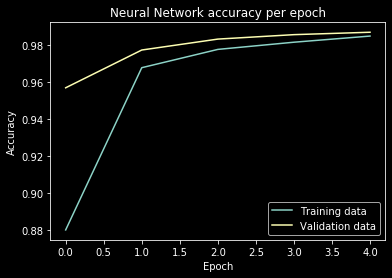

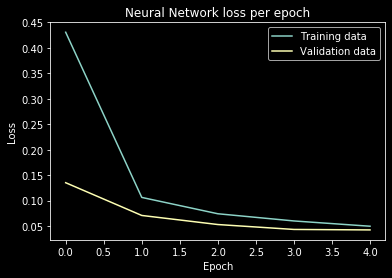

In [14]:
#Get accuracy for lenet
sequentialLoss, sequentialAccuracy = lenet.evaluate(testX, testY)
print('Lenet accuracy: ', sequentialAccuracy)
print('Lenet loss: ', sequentialLoss)

plt.style.use('dark_background')
plt.plot(lenetEpochHistory.history['acc'])
plt.plot(lenetEpochHistory.history['val_acc'])
plt.title('Neural Network accuracy per epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training data', 'Validation data'])
plt.show()

plt.style.use('dark_background')
plt.plot(lenetEpochHistory.history['loss'])
plt.plot(lenetEpochHistory.history['val_loss'])
plt.title('Neural Network loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training data', 'Validation data'])
plt.show()

In [15]:
utils.find_layer_idx(lenet, 'vis')
#lenet.layers[9].get_weights()
#lenet.layers[9].get_weights()[0][0]
#len(lenet.layers[9].get_weights()[1])
#lenet.layers[9].get_weights()[1]

9

In [16]:
get_num_filters(lenet.layers[9])

10

In [17]:
names = [weight.name for layer in lenet.layers for weight in layer.weights]
weights = lenet.get_weights()

for name, weight in zip(names, weights):
    print(name, weight.shape)

conv2d_1/kernel:0 (5, 5, 1, 20)
conv2d_1/bias:0 (20,)
conv2d_2/kernel:0 (5, 5, 20, 50)
conv2d_2/bias:0 (50,)
dense_1/kernel:0 (2450, 500)
dense_1/bias:0 (500,)
vis/kernel:0 (500, 10)
vis/bias:0 (10,)


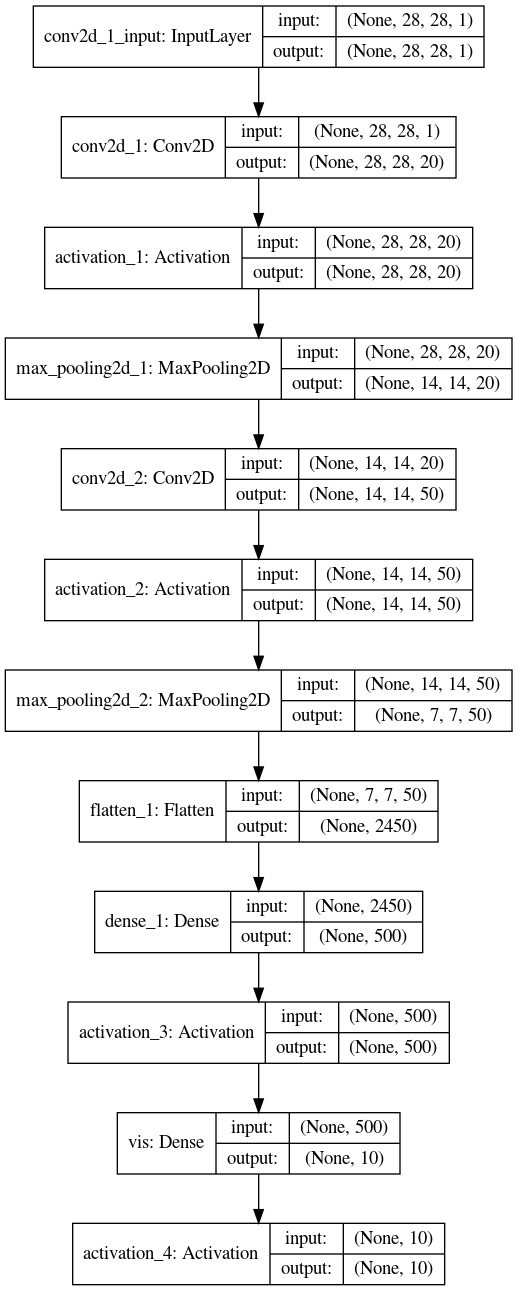

In [18]:
plot_model(lenet, to_file='model.png',show_shapes=True)

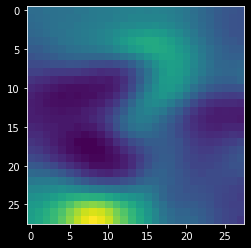

In [19]:
activation_map = visualize_activation(lenet,9,filter_indices=3)
activation_map = activation_map.reshape(28,28)
plt.imshow(activation_map,interpolation='nearest')

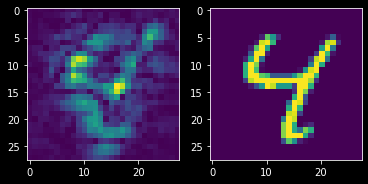

In [27]:
input_idx = 6
fig, ax = plt.subplots(nrows=1, ncols=2)
saliency_map = visualize_saliency(model = lenet,layer_idx = 9, filter_indices = np.argmax(testY[input_idx]), seed_input = testX[input_idx])
ax[0].imshow(saliency_map.reshape(28,28),interpolation='nearest')
ax[1].imshow(testX[input_idx].reshape(28,28))
plt.show()

In [21]:
#Generate multiple activation_maps
activation_maps = []
for classifier in lenets:
    activation_maps.append(visualize_activation(classifier,9,filter_indices=3))

In [31]:
#Generate multiple activation_maps
input_idx = 6
saliency_maps = []
for classifier in lenets:
    saliency_maps.append(visualize_saliency(model = classifier,layer_idx = 9, filter_indices = np.argmax(testY[input_idx]), seed_input = testX[input_idx]))

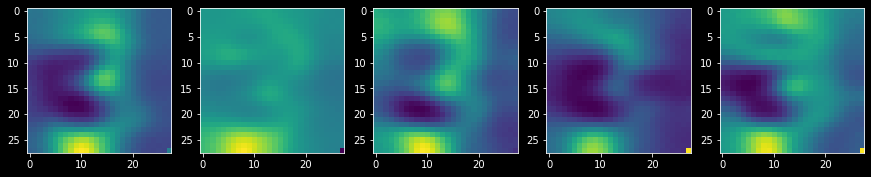

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=classifier_number, figsize = (15,15))
i = 0
for a_map in activation_maps:
    ax[i].imshow(a_map.reshape(28,28),interpolation='nearest')
    i = i+1

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=classifier_number+1, figsize = (15,15))
i = 0
for a_map in activation_maps:
    saliency_map = visualize_saliency(model = lenet,layer_idx = 9, filter_indices = np.argmax(testY[input_idx]), seed_input = testX[input_idx])
ax[0].imshow(saliency_map.reshape(28,28),interpolation='nearest')
ax[1].imshow(testX[input_idx].reshape(28,28))
plt.show()